# Geodesic Runtime

In [51]:
import jax.numpy as jnp

import os

import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from tabulate import tabulate

In [52]:
plt.rcParams.update({'font.size': 25})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [53]:
geometry = "riemannian"
T = 100
path = f'timing/{geometry}/'
manifold = "Sphere"
figure_path = '../figures/geodesic_runtime/'

In [54]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Loading Values

In [55]:
save_path = ''.join((path, manifold, '/'))

In [56]:
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
onlyfiles = [f for f in onlyfiles if f'T={T}.pkl' in f]

In [57]:
estimates = {}
for file in onlyfiles:
    file_path = ''.join((save_path, file))
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
    method = file.split(f'_{manifold}')[0]
    dim = file.replace(f"{method}_", '').replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_T={T}', '')
    if dim in estimates:
        estimates[dim] = dict(estimates[dim], **values)
    else:
        estimates[dim] = values

## Table Comparison

In [58]:
dims = list(estimates.keys())

mu_time = [estimates[key3][key2]['mu_time'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
std_time = [estimates[key3][key2]['std_time'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
length = [estimates[key3][key2]['length'] for key3,v3 in estimates.items()for key2,v2 in v3.items()]
iter_num = [estimates[key3][key2]['iterations'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
grad_norm = [estimates[key3][key2]['grad_norm'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
error = []
for key3, v3 in estimates.items():
    for key2, v2 in v3.items():
        val = estimates[key3][key2]
        if "error" in val.keys():
            error.append(val['error'])
        else:
            error.append(None)
max_iter = [estimates[key3][key2]['max_iter'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
tol = [estimates[key3][key2]['tol'] for key3,v3 in estimates.items() for key2,v2 in v3.items()]
method = [key2 for key3,v3 in estimates.items() for key2,v2 in v3.items()]
dims = [key3 for key3,v3 in estimates.items() for key2,v2 in v3.items()]

N_methods = len(list(set(method)))
#dims = sum([[d]*N_methods for d in dims], [])

In [59]:
names = [r"Dim", r"Method", #r"Error",
        r"Length", r"Iterations", r"grad_norm", r"mean time",
        r"std time", r"max_iter", r"tol"]

table_dict = {}
table_dict['Dim'] = dims
table_dict['Method'] = method
#table_dict['Error'] = error
table_dict['Length'] = length
table_dict['Iterations'] = iter_num
table_dict['grad_norm'] = grad_norm
table_dict['mu_time'] = mu_time
table_dict['std_time'] = std_time
table_dict['max_iter'] = max_iter
table_dict['tol'] = tol

print(tabulate(table_dict, headers=names, floatfmt=".4f"))


  Dim  Method          Length    Iterations    grad_norm    mean time    std time    max_iter     tol
-----  ------------  --------  ------------  -----------  -----------  ----------  ----------  ------
    3  SGD             2.7102     1000.0000       0.0108       0.2771      0.0024        1000  0.0001
    3  trust-exact     2.4342        5.0000       0.0000       5.3029      0.0323        1000  0.0001
    3  CG              2.4348      401.0000       0.0006     189.5336      2.0500        1000  0.0001
    3  BFGS            2.4342      183.0000       0.0005      63.5047      1.0277        1000  0.0001
    3  trust-ncg       2.4342        5.0000       0.0000     226.7762      3.2063        1000  0.0001
    3  ground_truth    2.4339                                                               0  0.0000
    3  GEORCE          2.4342       45.0000       0.0001       0.0752      0.0018        1000  0.0001
    3  init            2.6853                                                     

### Printing Table Version of Table

In [72]:
#methods = ['BFGS', 'ADAM', 'GEORCE']
#methods = ['SGD', 'CG', 'dogleg']
#methods = ['trust-ncg', 'trust-exact']

In [73]:
dims = [int(key3) for key3, v3 in estimates.items()]
dims.sort()
dims = [str(d) for d in dims]

In [74]:
def manifold_str(d):
    
    if manifold == "Sphere":
        return "\mathbb{S}^{"+f"{d}"+"}"
    elif manifold == "Ellipsoid":
        return "\mathrm{E}\\left( "+f"{d}"+" \\right)"
    elif manifold == "SPDN":
        return "\mathcal{P}\\left( "+f"{d}"+" \\right)"
    elif manifold == "T2":
        return "\mathbb{T}^{"+f"{d}"+"}"
    
    

In [75]:
for d in dims:
    print(f"${manifold_str(d)}$", end="")
    length = []
    iters = []
    mu_times = []
    std_times = []
    for m in methods:
        if m in estimates[d].keys():
            length.append(estimates[d][m]['length'])
            iters.append(estimates[d][m]['iterations'])
            mu_times.append(estimates[d][m]['mu_time'])
            std_times.append(estimates[d][m]['std_time'])
        else:
            length.append(jnp.nan)
            iters.append(jnp.nan)
            mu_times.append(jnp.nan)
            std_times.append(jnp.nan)
    length = jnp.stack(length)
    iters = jnp.stack(iters)
    mu_times = jnp.stack(mu_times)
    std_times = jnp.stack(std_times)
    best_length = jnp.where(length == jnp.nanmin(length))[0]
    best_iters = jnp.where(iters == jnp.nanmin(iters))[0]
    best_times = jnp.where(mu_times == jnp.nanmin(mu_times))[0]
    for i in range(len(length)):
        if jnp.isnan(length[i]):
            l = '-'
            it = '-'
            mu_time = '-'
            std_time = '-'
            print(f" & ${l}$", end="")
            print(f" & ${it}$", end="")
            print(f" & $-$", end="")
        else:
            if i in best_length:
                print(f" & $\\pmb{{{length[i]:.4f}}}$", end="")
            else:
                print(f" & ${length[i]:.4f}$", end="")
            if i in best_iters:
                print(f" & $\\pmb{{{int(iters[i])}}}$", end="")
            else:
                print(f" & ${int(iters[i])}$", end="")
            if i in best_times:
                print(f" & $\\pmb{{{mu_times[i]:.4f}}} \pm \\pmb{{ {std_times[i]:.4f} }}$", end="")
            else:
                print(f" & ${mu_times[i]:.4f} \pm {std_times[i]:.4f}$", end="")
    print(" \\\ ")

$\mathbb{S}^{2}$ & $2.4063$ & $1000$ & $\pmb{0.2726} \pm \pmb{ 0.0006 }$ & $2.2744$ & $445$ & $215.5032 \pm 3.4804$ & $\pmb{2.2742}$ & $\pmb{3}$ & $3.6036 \pm 0.0604$ \\ 
$\mathbb{S}^{3}$ & $2.7102$ & $1000$ & $\pmb{0.2771} \pm \pmb{ 0.0024 }$ & $2.4348$ & $401$ & $189.5336 \pm 2.0500$ & $\pmb{2.4342}$ & $\pmb{4}$ & $4.5207 \pm 0.0436$ \\ 
$\mathbb{S}^{5}$ & $3.0827$ & $1000$ & $\pmb{0.3019} \pm \pmb{ 0.0018 }$ & $\pmb{2.3807}$ & $340$ & $165.2034 \pm 1.5860$ & $3.1069$ & $\pmb{0}$ & $0.9449 \pm 0.0196$ \\ 
$\mathbb{S}^{10}$ & $3.4578$ & $1000$ & $\pmb{0.3339} \pm \pmb{ 0.0011 }$ & $\pmb{1.9801}$ & $268$ & $140.5511 \pm 1.8054$ & $3.5092$ & $\pmb{0}$ & $1.0036 \pm 0.0171$ \\ 
$\mathbb{S}^{20}$ & $3.5726$ & $1000$ & $\pmb{0.3694} \pm \pmb{ 0.0062 }$ & $\pmb{1.4932}$ & $325$ & $200.9558 \pm 0.0603$ & $3.6632$ & $\pmb{0}$ & $1.2081 \pm 0.0173$ \\ 
$\mathbb{S}^{50}$ & $3.2831$ & $1000$ & $\pmb{0.5521} \pm \pmb{ 0.0005 }$ & $\pmb{1.2167}$ & $\pmb{69}$ & $59.1987 \pm 0.1045$ & $-$ & $-$ & $-

## Plotting $\mathbb{S}^{n}$ and Ellipsoid(n) for $T=100$

In [41]:
geometry = "riemannian"
T = 100
path = f'timing/{geometry}/'
figure_path = '../figures/geodesic_runtime/'

In [42]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Loading $\mathbb{S}^{n}$

In [43]:
manifold = "Sphere"
save_path = ''.join((path, f"{manifold}", '/'))

In [44]:
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
onlyfiles = [f for f in onlyfiles if f'T={T}.pkl' in f]

In [45]:
sphere_estimates = {}
for file in onlyfiles:
    file_path = ''.join((save_path, file))
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
    method = file.split(f'_{manifold}')[0]
    dim = file.replace(f"{method}_", '').replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_T={T}', '')
    if dim in sphere_estimates:
        sphere_estimates[dim] = dict(sphere_estimates[dim], **values)
    else:
        sphere_estimates[dim] = values

## Loading Ellipsoid(n)

In [46]:
manifold = "Ellipsoid"
save_path = ''.join((path, f"{manifold}", '/'))

In [47]:
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
onlyfiles = [f for f in onlyfiles if f'T={T}.pkl' in f]

In [48]:
ellipsoid_estimates = {}
for file in onlyfiles:
    file_path = ''.join((save_path, file))
    with open(file_path, 'rb') as f:
        values = pickle.load(f)
    method = file.split(f'_{manifold}')[0]
    dim = file.replace(f"{method}_", '').replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_T={T}', '')
    if dim in ellipsoid_estimates:
        ellipsoid_estimates[dim] = dict(ellipsoid_estimates[dim], **values)
    else:
        ellipsoid_estimates[dim] = values

## Table Comparison

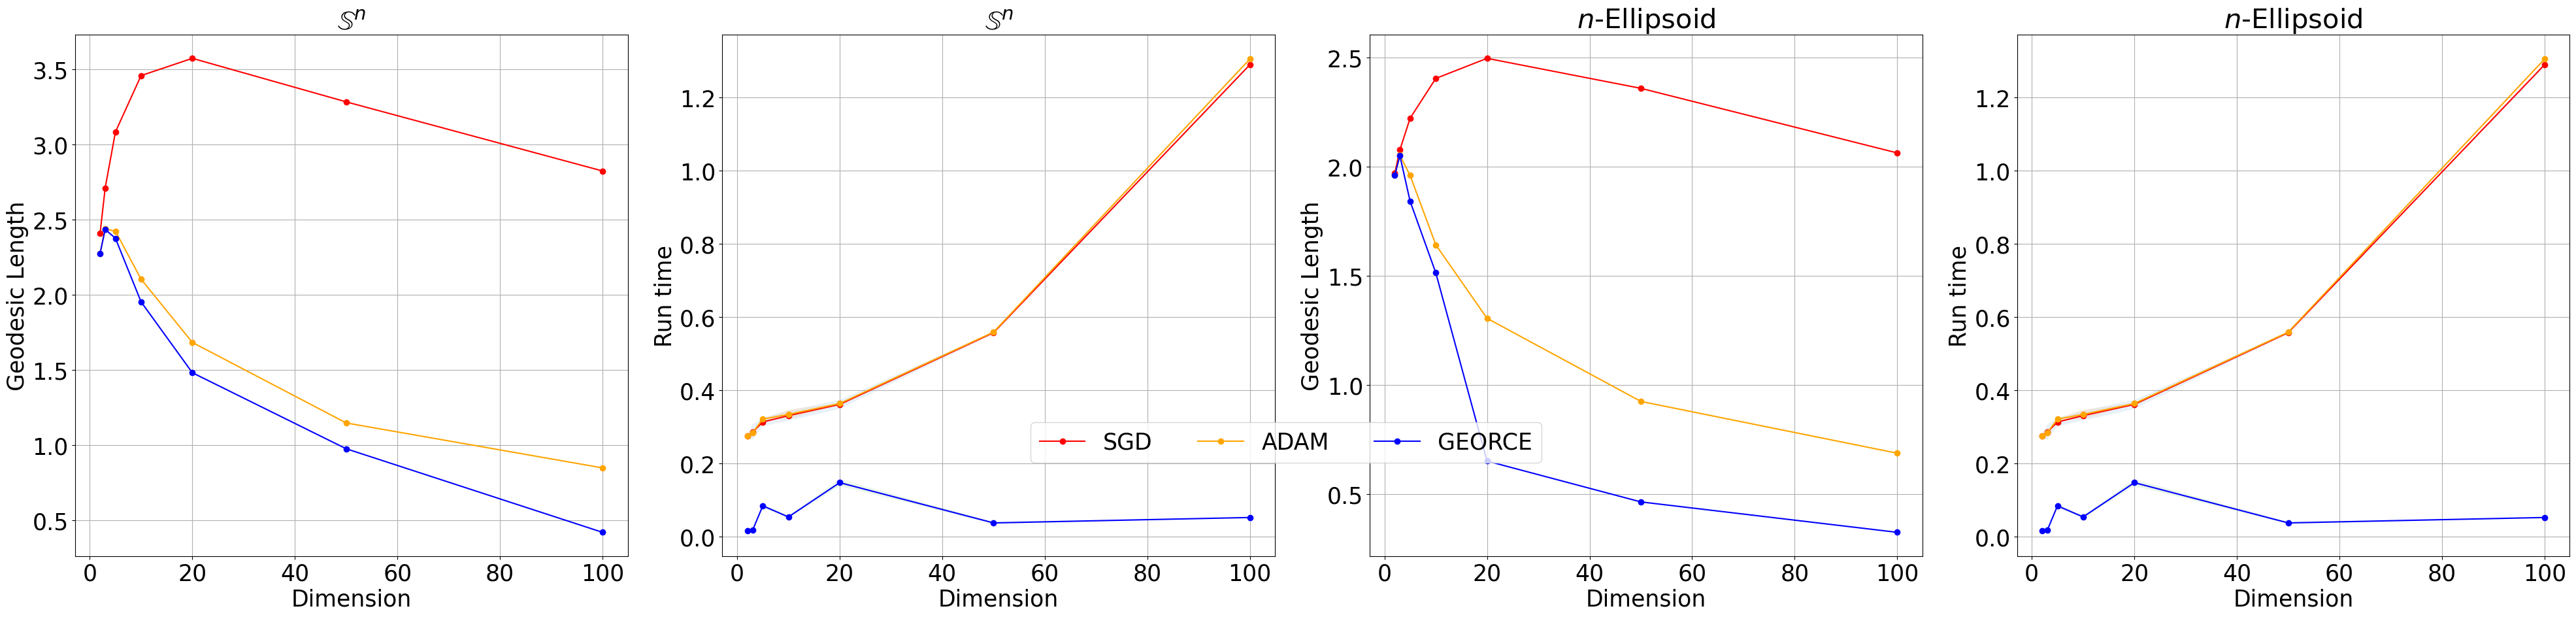

In [50]:
color = ['red', 'orange', 'blue']
methods = ['SGD', 'ADAM', 'GEORCE']
dims = [2,3,5,10,20,50,100]

fig = plt.figure(figsize=(40,10))
ax = fig.add_subplot(141)
for j in range(len(methods)):
    vals = []
    for d in dims:
        if 'length' in sphere_estimates[str(d)][methods[j]].keys():
            vals.append(sphere_estimates[str(d)][methods[j]]['length'])
        else:
            vals.append(jnp.nan)
    vals = jnp.stack(vals)
    ax.plot(dims, vals, '-o', color=color[j])
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Geodesic Length')
ax.set_title(r"$\mathbb{S}^{n}$")
ax.grid(True)
    
ax = fig.add_subplot(142)
for j in range(len(methods)):
    vals = []
    vals2 = []
    for d in dims:
        if 'mu_time' in ellipsoid_estimates[str(d)][methods[j]].keys():
            vals.append(ellipsoid_estimates[str(d)][methods[j]]['mu_time'])
            vals2.append(ellipsoid_estimates[str(d)][methods[j]]['std_time'])
        else:
            vals.append(jnp.nan)
            vals2.append(jnp.nan)
    vals = jnp.stack(vals)
    vals2 = jnp.stack(vals2)
    ax.plot(dims, vals, '-o', color=color[j])
    ax.fill_between(
                    dims,
                    jnp.maximum(vals - 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    jnp.maximum(vals + 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    alpha=0.1,
                )
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Run time')
ax.set_title(r"$\mathbb{S}^{n}$")
ax.grid(True)

ax = fig.add_subplot(143)
for j in range(len(methods)):
    vals = []
    for d in dims:
        if 'length' in ellipsoid_estimates[str(d)][methods[j]].keys():
            vals.append(ellipsoid_estimates[str(d)][methods[j]]['length'])
        else:
            vals.append(jnp.nan)
    vals = jnp.stack(vals)
    ax.plot(dims, vals, '-o', color=color[j])
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Geodesic Length')
ax.set_title(r"$n$-Ellipsoid")
ax.grid(True)
    
ax = fig.add_subplot(144)
for j in range(len(methods)):
    vals = []
    vals2 = []
    for d in dims:
        if 'mu_time' in ellipsoid_estimates[str(d)][methods[j]].keys():
            vals.append(ellipsoid_estimates[str(d)][methods[j]]['mu_time'])
            vals2.append(ellipsoid_estimates[str(d)][methods[j]]['std_time'])
        else:
            vals.append(jnp.nan)
            vals2.append(jnp.nan)
    vals = jnp.stack(vals)
    vals2 = jnp.stack(vals2)
    ax.plot(dims, vals, '-o', color=color[j], label=methods[j])
    ax.fill_between(
                    dims,
                    jnp.maximum(vals - 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    jnp.maximum(vals + 1.96 * vals2, 
                                jnp.zeros_like(vals)),
                    alpha=0.1,
                )
ax.set_xlabel(f'Dimension')
ax.set_ylabel(f'Run time')
ax.set_title(r"$n$-Ellipsoid")
ax.grid(True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.40,0.25), ncol=5)



fig.tight_layout()

plt.show()

save_path = f'{figure_path}sphere_ellipsoid_runtime.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')